In [6]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.special import expi
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix

In [160]:
def csrt(conc,ti, tau=2, ts =[], cinj=[0] ):
    '''
    this function provides the time derivative for the concentration 
    in a mixing tank at ti.
    CSRT time differencial
    f = d/dt(concentration) = slope = n/tau*(delta concentration)
        delta concentration in the equation above is the difference between 
        concentration in the nth tank and n-1th tank     
    input:
            conc : a numpy list of concentrat in n number of nodes at time step ti
            ti   : time at which the slope is being derived (note: in this model ti is not used)
            n    : number of tanks in series
            tau  : some parameter of the mixing tank (units = time)
            cinj : the concentration of the fluid being injected into the 0th mixing tank
                   at the ith time step.
    '''
    
    n = len(conc)
    idx =0#= np.where(ts==ti)[0][0] # find which time step we are on[]
    #print(cinj[idx],n)
    c = np.append(cinj[idx], conc) # we append the injection 
    slope = n/tau*(c[:-1]-c[1:])
    return(slope)

In [161]:
def mixanalytical(ts, tau,c0=1,N=1):
    match N:
        case 1:
            return c0*np.exp(-ts/tau)
        case 2:
            return 2*c0*ts/tau*np.exp(-2*ts/tau)
        case 3:
            return c0*9*ts*ts/2/tau/tau*np.exp(-3*ts/tau)
        case other:
            Print('Not implemented')
            return(None)


In [285]:
class ODEsolvers():
    '''
    a class containing solvers that solves for an euation of the form 
    d/dt(y) = f(y,t)
    '''
    def __init__(self, y_init, deltaTs, slope_func):
        '''
        initiate the object with the old value of y 
        y_init : initial values of the variable before simulation starts
        deltaTs: a list of deltaTs over which the new values for y are to be calculated
        f: is the function that provides the time derivative at each node 
        '''
        self.y_0 = y_init
        self.deltaTs = deltaTs
        self.slope = slope_func
        self.solutions={}
        #time stamp after each time step
        ts = [sum(self.deltaTs[:i+1])for i in range(len(self.deltaTs))] 
        self.ts = np.array(ts)
        
    def euler(self,y,t, dt,*pparams, **nparams):
        '''
        returns the increment to the parameter y 
        '''
        eulerstep = self.slope(y,t,*pparams,**nparams)*dt
        return(eulerstep)
    
    def rk2(self,y,t, dt,*pparams, **nparams):
        '''
        returns the increment to the parameter y 
        '''
        k1=dt*self.slope(y,t,*pparams,**nparams)
        k2=dt*self.slope(y+k1/2,t+dt/2,*pparams,**nparams)
        return k2
    
    def rk4(self,y,t, dt,*pparams, **nparams):
        '''
        returns the increment to the parameter y 
        '''
        k1=dt*self.slope(y,t,*pparams,**nparams)
        k2=dt*self.slope(y+k1/2,t+dt/2,*pparams,**nparams)
        k3=dt*self.slope(y+k2/2,t+dt/2,*pparams,**nparams)
        k4=dt*self.slope(y+k3,t+dt,*pparams,**nparams)
        return (k1+2*k2+2*k3+k4)/6
    
    def solver(self, *pparams, method='euler', **nparams):
        solution = []
        
        match method:
            case 'euler':
                solver = self.euler
            case 'rk2':
                solver = self.rk2
            case 'rk4':
                solver = self.rk4
            case other:
                print('Not implemented, choosing rk4 instead.')
                solver = self.rk4
            
        y_now = self.y_0    # set y values 
        for ti,dt in zip(self.ts, self.deltaTs):
            step = solver(y_now, ti, dt, *pparams, **nparams)
            y_next = y_now+step
            solution.append(y_next)
            y_now= y_next
        solution = np.array(solution)
        self.solutions[method]=solution
        return(solution[:,-1])
            
        

In [326]:
class CSRTModel(ODEsolvers):
    '''
    This class makes a Continuous-Stirred-Tank-Reactor model 
    and provides methods to perform time domain simulations on it 
    '''
    def __init__(self, tau=2, N=1, dt=3, Tmax=20, y_init='first'):
        '''
        params:  make sure all the units are consistent
            tau : V/q time taken to replace the whole volume of the tank
            N : number of subtanks the whole volume is divided into.
            dt: time diff between each simulation step
            Tmax  : max simulation time 
            y_init : initial concentration of tracer in each spatial grid
                   : takes values {'first', 'empty', list }
                   : 'first' - case where first (0th) cell has a tracer conc
                   : 'empty' - case where the whole volume has 0 tracer conc
                   : list: list of tracer conc in each of the grid cell

        '''
        self.N = N
        self.tau = tau
        self.dt = dt
        print(dt)
        self.Tmax = Tmax

        self.Nt = int(Tmax/dt)  # number of grid elements on the time axis

        # set initial condition of concs before sim starts
        match y_init:
            case 'first':
                y_init = np.append(1, np.zeros(self.N-1))
            case 'empty':
                y_init = np.zeros(self.N)
            case other:
                y_init = y_init

        if cinj is None:
            self.cinj = np.zeros(self.Nt)  # no injection
        else:
            self.cinj = cinj

        deltaTs = np.ones(self.Nt)*dt
        #print(deltaTs)
        ts = [0] + [sum(deltaTs[:i+1])for i in range(self.Nt)]
        self.ts = np.array(ts)
        self.nparams = {'tau': tau, 'ts': solver.ts, 'cinj': cinj}

        #initiate ODEsolver
        ODEsolvers.__init__(self, y_init=y_init,deltaTs=deltaTs, slope_func=self.csrt)

    def csrt(self, conc, ti, tau=2, ts=[], cinj=[0]):
        '''
        this function provides the time derivative for the concentration 
        in a mixing tank at ti.
        CSRT time differencial
        f = d/dt(concentration) = slope = n/tau*(delta concentration)
            delta concentration in the equation above is the difference between 
            concentration in the nth tank and n-1th tank     
        input:
                conc : a numpy list of concentrat in n number of nodes at time step ti
                ti   : time at which the slope is being derived (note: in this model ti is not used)
                n    : number of tanks in series
                tau  : some parameter of the mixing tank (units = time)
                cinj : the concentration of the fluid being injected into the 0th mixing tank
                       at the ith time step.
        '''

        n = len(conc)
        idx = 0  # = np.where(ts==ti)[0][0] # find which time step we are on[]
        # print(cinj[idx],n)
        c = np.append(cinj[idx], conc)  # we append the injection
        slope = n/tau*(c[:-1]-c[1:])
        return(slope)

    def analytical(self, c0=1):
        ts = self.ts
        tau = self.tau
        match self.N:
            case 1:
                return c0*np.exp(-ts/tau)
            case 2:
                return 2*c0*ts/tau*np.exp(-2*ts/tau)
            case 3:
                return c0*9*ts*ts/2/tau/tau*np.exp(-3*ts/tau)
            case other:
                Print('Not implemented')
                return(None)

In [327]:
def comparision_plot(ts,analitical, soln1, soln2, soln3):
    
    fig, axs=plt.subplots(nrows=2)
    
    ax=axs[0]
    ax.plot(ts, analitical,'-o',markersize=7, label='analytical')
    ax.plot(ts, soln1,'-*',markersize=7, label='numerical, euler')
    ax.plot(ts, soln2,'-*',markersize=5, label='numerical, rk2')
    ax.plot(ts, soln3,'-*',markersize=2, label='numerical, rk4')
    ax.set(xlabel='time ', ylabel='conc. at tank exit')
    ax.set(title = f'Change in exit conc over time,\n N of tank:{N}, deltaT: {dt}')
    ax.legend()
    
    ax=axs[1]
    #ax.plot(ts, analitical,'-o',markersize=7, label='analytical')
    ax.plot(ts, np.abs(soln1-analitical),'-*',markersize=7, label='numerical, euler')
    ax.plot(ts, np.abs(soln2-analitical),'-*',markersize=5, label='numerical, rk2')
    ax.plot(ts, np.abs(soln3-analitical),'-*',markersize=2, label='numerical, rk4')
    ax.set(xlabel='time ', ylabel='error', yscale='log')
    ax.set(title = f'Error,\n N of tank:{N}, deltaT: {dt}')
    ax.legend()
    plt.tight_layout()


In [328]:
def make(tau=2, N=1,dt=3,Tmax=20,y_init='first'):

    model = CSRTModel(tau=tau, N=N, dt=dt, Tmax=Tmax, y_init=y_init)
    nparams = model.nparams#

    soln1 =model.solver(**nparams)
    soln2 =model.solver(method='rk2',**nparams)
    soln3 =model.solver(method='rk4',**nparams)
    ts=model.ts
    analitical= model.analytical()
    comparision_plot(ts,analitical, soln1, soln2, soln3)

3


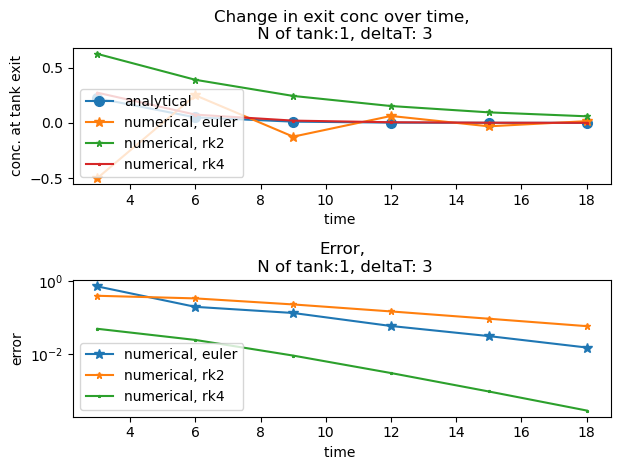

In [329]:
make(tau=2, N=1,dt=3,Tmax=20,y_init='first')

1


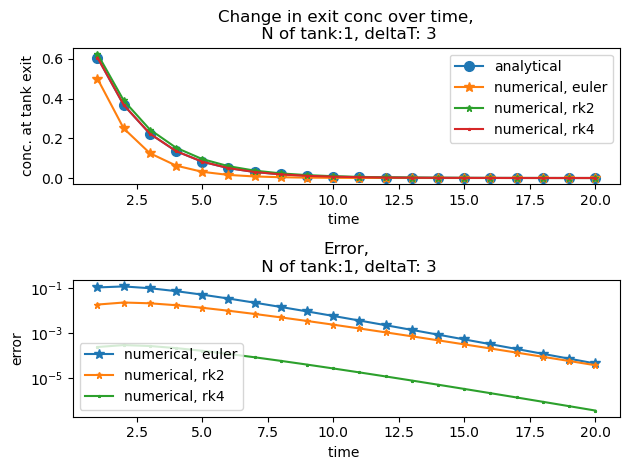

In [330]:
make(tau=2, N=1,dt=1,Tmax=20,y_init='first')

0.2


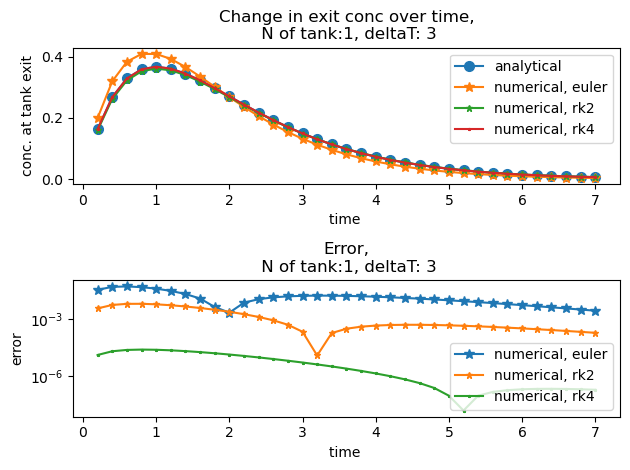

In [331]:
make(tau=2, y_init='first', dt = .2,Tmax = 7,N=2)

0.01


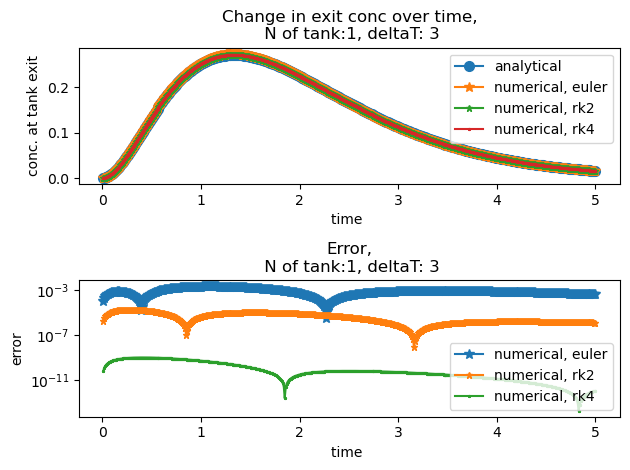

In [332]:
make(dt = .01,Tmax = 5,N=3)